# Homework 8 Assignment 1

In [1]:
# ensure compatability btw python 2 and 3

from __future__  import print_function, division

In [2]:
# importing packages

import os
import io
import urllib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl
%pylab inline

import geopandas as gpd
import json
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import LineString, Point
from geopandas.tools import sjoin

Populating the interactive namespace from numpy and matplotlib


In [3]:
os.environ["PUIDATA"] = "%s/001_PUI/PUIDATA"%os.getenv("HOME")
print("Path to PUIDATA", os.getenv("PUIDATA"))

Path to PUIDATA /nfshome/qg412/001_PUI/PUIDATA


## Data Sources

3 data sets were utilized for this plot: 

1) Financial empowerment center from NYC open data @ https://data.cityofnewyork.us/Business/Financial-Empowerment-Centers/dt2z-amuf

2) Public use microdata area (PUMA) for NYC @ https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile

3) Percent of people below poverty level in the past 12 months from American Fact Finder @ https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_17_1YR_GCT1701.ST50&prodType=table


## qg412's comment on Reproducibility & Data Privacy

In the spirit of reproducibility, all data sources must be made avaliable and users must be able to take the same line of codes to generate the same plot of results. 

However, there is no way to read data from the American Fact Finder directly from an url link. Instead, data must be manually downloaded and uploaded into the enduser's own cloud server/local drive.

The unfortunate construct of American Fact Finder and its data does not render this piece of work un-reproducible though, as the enduser can still access the main url to download the raw data. The plots are still reproducible using the same lines of code.  

For convenience sake, the raw data from American Fact finder will be provided on Github. I am aware of the general rule of thumb that no data should be uploaded into github due to data privacy concerns, but this is one instance where the data is already publically avaliable online, thus this does not violate any data privacy concern too.    

## Data Wrangling

**For Financial Empowerment Centers**

In [4]:
# downloading the data from an url link
!curl https://data.cityofnewyork.us/api/views/dt2z-amuf/rows.csv?accessType=DOWNLOAD > fec.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7965    0  7965    0     0  31610      0 --:--:-- --:--:-- --:--:-- 31733


In [5]:
# moving the downloaded data into PUIDATA folder
!mv fec.csv $PUIDATA

In [6]:
# reading the downloaded csv file as a pandas dataframe
fec = pd.read_csv("%s/fec.csv"%os.getenv("PUIDATA"))
fec.head()

,Provider,Host Organization,Building,Street,City,Borough,Postcode,Site Location Address,Days Open,Hours,...,Community Board,BBL,NTA,X Coordinates,Y Coordinates,Latitude,Longitude,Census Tract,BIN,Location
0,Phipps Neighborhoods,Phipps Neighborhoods Opportunity Center at Mel...,3125,Third Avenue,Bronx,Bronx,10451,3125 Third Avenue,Monday-Friday,"Mon, Thurs, Fri 9am - 6pm; Tues & Wed 9am - 5pm",...,201,2023800051,BX34,1008640,238751,40.821958,-73.911877,69,2000000,"(40.82195823377828, -73.91187741258507)"
1,Phipps Neighborhoods,Phipps Neighborhoods Opportunity Center at Wes...,1030,East 178th Street,Bronx,Bronx,10460,1030 East 178th Street,"Monday, Tuesday, Wednesday, and Friday",9am-5pm,...,206,2031300100,BX17,1017491,245755,40.841153,-73.879864,361,2013245,"(40.84115331040014, -73.87986352757528)"
2,Phipps Neighborhoods,Catholic Charities Homebase (Bronx),2155,Blackrock Avenue,Bronx,Bronx,10472,2155 Blackrock Avenue,Wednesday,9am-5pm,...,209,2038080038,BX59,1025266,241291,40.828868,-73.851791,78,2119153,"(40.82886824726105, -73.8517912044293)"
3,Bedford Stuyvesant Restoration Corporation,Brooklyn Cooperative Federal Credit Union,834,Dekalb Avenue,Brooklyn,Brooklyn,11237,834 Dekalb Avenue,"Tuesday, Friday & Saturday","Tues 9am-4pm, Fri 9am-4pm, Sat 9am-2pm",...,303,3017810040,BK75,1000011,191508,40.692308,-73.943165,261,3413813,"(40.692307919526726, -73.94316526337892)"
4,Bedford Stuyvesant Restoration Corporation,Bedford Stuyvesant Restoration Corporation,1368,Fulton Street,Brooklyn,Brooklyn,11216,1368 Fulton Street,Monday-Friday,"M-W & F 9am-6pm, Th 9am -8pm",...,303,3018620014,BK61,999306,187087,40.680175,-73.945717,247,3053786,"(40.680174516304774, -73.9457173974154)"


In [7]:
# reading fec as a geodataframe so that it can be plotted later 
fec = gpd.GeoDataFrame(fec)

In [8]:
# creating a lonlat and geometry column for plotting as a map later
fec['lonlat']=list(zip(fec.Longitude,fec.Latitude))
fec['geometry'] = fec[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
fec.head()

,Provider,Host Organization,Building,Street,City,Borough,Postcode,Site Location Address,Days Open,Hours,...,NTA,X Coordinates,Y Coordinates,Latitude,Longitude,Census Tract,BIN,Location,lonlat,geometry
0,Phipps Neighborhoods,Phipps Neighborhoods Opportunity Center at Mel...,3125,Third Avenue,Bronx,Bronx,10451,3125 Third Avenue,Monday-Friday,"Mon, Thurs, Fri 9am - 6pm; Tues & Wed 9am - 5pm",...,BX34,1008640,238751,40.821958,-73.911877,69,2000000,"(40.82195823377828, -73.91187741258507)","(-73.9118774126, 40.8219582338)",POINT (-73.91187741258506 40.82195823377828)
1,Phipps Neighborhoods,Phipps Neighborhoods Opportunity Center at Wes...,1030,East 178th Street,Bronx,Bronx,10460,1030 East 178th Street,"Monday, Tuesday, Wednesday, and Friday",9am-5pm,...,BX17,1017491,245755,40.841153,-73.879864,361,2013245,"(40.84115331040014, -73.87986352757528)","(-73.8798635276, 40.8411533104)",POINT (-73.87986352757528 40.84115331040014)
2,Phipps Neighborhoods,Catholic Charities Homebase (Bronx),2155,Blackrock Avenue,Bronx,Bronx,10472,2155 Blackrock Avenue,Wednesday,9am-5pm,...,BX59,1025266,241291,40.828868,-73.851791,78,2119153,"(40.82886824726105, -73.8517912044293)","(-73.8517912044, 40.8288682473)",POINT (-73.85179120442929 40.82886824726105)
3,Bedford Stuyvesant Restoration Corporation,Brooklyn Cooperative Federal Credit Union,834,Dekalb Avenue,Brooklyn,Brooklyn,11237,834 Dekalb Avenue,"Tuesday, Friday & Saturday","Tues 9am-4pm, Fri 9am-4pm, Sat 9am-2pm",...,BK75,1000011,191508,40.692308,-73.943165,261,3413813,"(40.692307919526726, -73.94316526337892)","(-73.9431652634, 40.6923079195)",POINT (-73.94316526337893 40.69230791952673)
4,Bedford Stuyvesant Restoration Corporation,Bedford Stuyvesant Restoration Corporation,1368,Fulton Street,Brooklyn,Brooklyn,11216,1368 Fulton Street,Monday-Friday,"M-W & F 9am-6pm, Th 9am -8pm",...,BK61,999306,187087,40.680175,-73.945717,247,3053786,"(40.680174516304774, -73.9457173974154)","(-73.9457173974, 40.6801745163)",POINT (-73.94571739741541 40.68017451630477)


In [9]:
fec.columns

Index(['Provider', 'Host Organization', 'Building', 'Street', 'City ',
       'Borough', 'Postcode', 'Site Location Address', 'Days Open', 'Hours',
       'Language(s)', 'Telephone', 'Council District', 'Community Board',
       'BBL', 'NTA', 'X Coordinates', 'Y Coordinates', 'Latitude', 'Longitude',
       'Census Tract', 'BIN', 'Location', 'lonlat', 'geometry'],
      dtype='object')

In [10]:
# dropping the columns not required for now
fec.drop(['Host Organization', 'Building', 'Street', 'City ',
       'Postcode', 'Site Location Address', 'Days Open', 'Hours',
       'Language(s)', 'Telephone', 'Council District', 'Community Board',
       'BBL', 'NTA', 'X Coordinates', 'Y Coordinates', 'Latitude', 'Longitude',
       'Census Tract', 'BIN', 'Location', 'lonlat'], axis=1, inplace=True)
fec.head()

,Provider,Borough,geometry
0,Phipps Neighborhoods,Bronx,POINT (-73.91187741258506 40.82195823377828)
1,Phipps Neighborhoods,Bronx,POINT (-73.87986352757528 40.84115331040014)
2,Phipps Neighborhoods,Bronx,POINT (-73.85179120442929 40.82886824726105)
3,Bedford Stuyvesant Restoration Corporation,Brooklyn,POINT (-73.94316526337893 40.69230791952673)
4,Bedford Stuyvesant Restoration Corporation,Brooklyn,POINT (-73.94571739741541 40.68017451630477)


**For PUMA shapefile**

In [11]:
#downloading the data online using urllib
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

urllib.request.urlretrieve(url, "pumashp")

('pumashp', <http.client.HTTPMessage at 0x7f0a8bcf2048>)

In [12]:
# unzipping the file and saving it into a folder named puma
os.system("unzip " "pumashp" + " -d " + os.getenv('PUIDATA') + "/puma")

0

In [13]:
# renaming the files to a standardized name to ensure reproducibility
for filename in os.listdir(os.getenv('PUIDATA') + "/puma"):
    if filename.endswith(".shp"):
        os.rename(os.getenv('PUIDATA') + "/puma/" + filename, os.getenv('PUIDATA') + "/puma/" + "puma.shp")
    if filename.endswith(".dbf"):
        os.rename(os.getenv('PUIDATA') + "/puma/" + filename, os.getenv('PUIDATA') + "/puma/" + "puma.dbf")
    if filename.endswith(".prj"):
        os.rename(os.getenv('PUIDATA') + "/puma/" + filename, os.getenv('PUIDATA') + "/puma/" + "puma.prj")
    if filename.endswith(".shx"):
        os.rename(os.getenv('PUIDATA') + "/puma/" + filename, os.getenv('PUIDATA') + "/puma/" + "puma.shx")

In [14]:
# reading and saving the shapefile using a geodataframe
pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/puma/" +'puma.shp')

In [15]:
#reading the shapefile
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [16]:
pumashp.dtypes

puma           object
shape_area    float64
shape_leng    float64
geometry       object
dtype: object

In [17]:
pumashp['puma'] = pumashp['puma'].astype(int)
pumashp.dtypes

puma            int64
shape_area    float64
shape_leng    float64
geometry       object
dtype: object

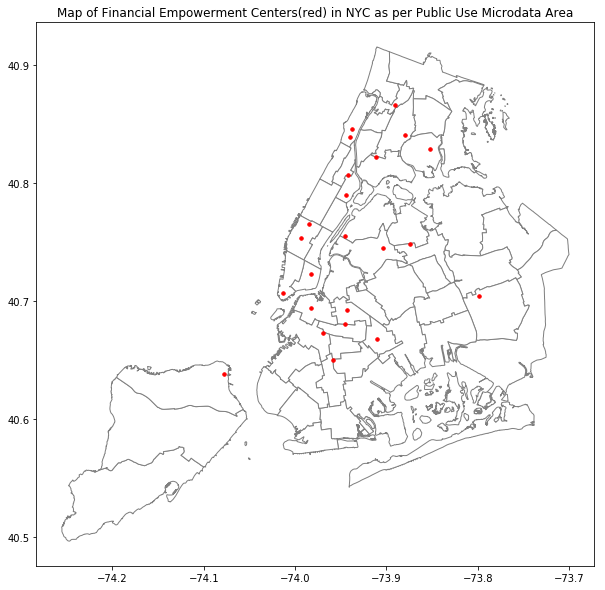

In [18]:
# mapping fec and puma 
f, ax = plt.subplots(figsize=(10,10))
base = pumashp.plot(ax=ax, color='white', edgecolor="grey", figsize=(10,10)), fec.plot(ax=ax, color='red', markersize=12, alpha=1)
ax.set_title("Map of Financial Empowerment Centers(red) in NYC as per Public Use Microdata Area");

**For the poverty data**

As aforementioned, data is not directly avaliable via a url, but it can be accessed from the main url: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_17_1YR_GCT1701.ST50&prodType=table > Select Download

In [19]:
#reading the poverty csv dataset
poverty = pd.read_csv(os.getenv("PUIDATA") + "/ACS_17_1YR_GCT1701.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
poverty.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,16.9,0.5
2,0100100,15.8,2.1
3,0100200,9.8,2.4
4,0100301,13.3,3.1


In [20]:
# dropping the additional column
poverty.drop(0, inplace=True)
poverty.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,01,16.9,0.5
2,0100100,15.8,2.1
3,0100200,9.8,2.4
4,0100301,13.3,3.1
5,0100302,20.5,4.0


In [21]:
# finding out the data types using the dtypes command
poverty.dtypes

GCT_STUB.target-geo-id2    object
HC01                       object
HC02                       object
dtype: object

In [22]:
# convert the GCT column into integer
poverty['GCT_STUB.target-geo-id2'] = poverty['GCT_STUB.target-geo-id2'].astype(int)
poverty['HC01'] = poverty['HC01'].astype(float)
poverty.dtypes

GCT_STUB.target-geo-id2      int64
HC01                       float64
HC02                        object
dtype: object

In [23]:
#creating a gid column to be joined to puma later 
poverty["gid"] = poverty['GCT_STUB.target-geo-id2'] - 3600000
poverty.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,1,16.9,0.5,-3599999
2,100100,15.8,2.1,-3499900
3,100200,9.8,2.4,-3499800
4,100301,13.3,3.1,-3499699
5,100302,20.5,4.0,-3499698


In [24]:
pumashp2 = pumashp.merge(poverty, left_on='puma', right_on='gid')
pumashp2

,puma,shape_area,shape_leng,geometry,GCT_STUB.target-geo-id2,HC01,HC02,gid
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3603701,18.5,4.0,3701
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3603702,14.6,3.3,3702
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3603703,10.2,2.6,3703
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3603704,16.4,2.8,3704
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,3604015,16.8,2.7,4015
5,4016,1.207135e+08,109477.751817,POLYGON ((-73.94405560932151 40.61199284173428...,3604016,14.0,2.4,4016
6,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,3603705,35.8,3.9,3705
7,3706,4.388687e+07,51799.404183,"POLYGON ((-73.88785196328796 40.8721141761279,...",3603706,32.9,4.5,3706
8,3707,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",3603707,36.4,4.4,3707
9,4006,6.184965e+07,42555.996557,POLYGON ((-73.95526963654763 40.67012490485409...,3604006,20.0,3.8,4006


# Final Plot

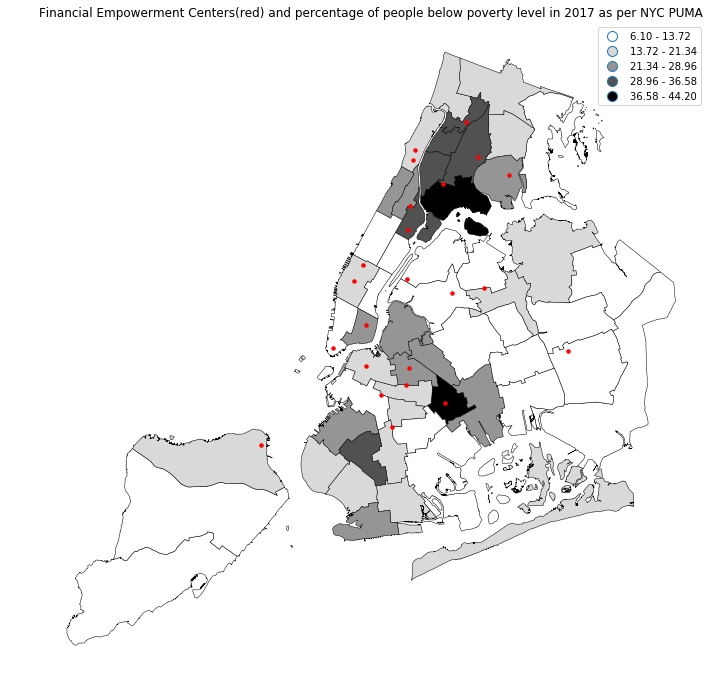

In [29]:
f, ax = plt.subplots(figsize=(12,12))
base = pumashp2.plot(column='HC01',cmap='Greys', edgecolor="black", alpha=1,
                  linewidth=0.5,ax=ax, scheme="Equal_interval", legend=True), fec.plot(ax=ax, color='red', markersize=12, alpha=1)
ax.axis('off')
ax.set_title("Financial Empowerment Centers(red) and percentage of people below poverty level in 2017 as per NYC PUMA");

Figure 1: Map of Financial Empowerment Centers(red) and percentage of people below poverty level in NYC 2017, as per Public Use Microdata Area. The Financial Empowerment Center (FECs) is a citywide service meant to provide free financial counseling to New Yorkers, funded and piloted by Bloomberg Philanthropies. The main but unofficial target group of FECs are low-income individuals. Therefore it is meaningful to juxatapose FECs with the percentage of people below poverty line in 2017. From the plot, it can be observed that generally, there is a positive correlation between areas of high percentage of people below poverty line and concentration of FECs, such as in Bronx and upper Manhatten and vice versa in Staten Islands and eastern Queens. However, areas such as southern brooklyn is supposedly underserved by FECs as there is relatively high percentage of people under poverty line but no FECs in vicinity. 